In [2]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
from venn import venn

HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()
ExpMat, ExpZscoreMat, ExpMatNorm, ExpZscoreMatNorm = LoadExpressionMatrices()
ExpMat = pd.read_csv("dat/Jon_data/energy-exp_level.csv", index_col="ROW", low_memory=False)
gnomad_cons = pd.read_csv("../dat/genes/gnomad.v2.1.1.lof_metrics.by_gene.txt",
                          delimiter="\t", index_col="gene", low_memory=False)

### 0. Select Mutations for ASD & Sibling

In [542]:
ASD_Discov_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Discov_DNVs.txt", delimiter="\t")
ASD_Rep_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Rep_DNVs.txt", delimiter="\t")
ASD_Discov_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Discov_Trios.txt", delimiter="\t")
ASD_Rep_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Rep_Trios.txt", delimiter="\t")
AllMuts = pd.concat([ASD_Discov_Muts, ASD_Rep_Muts])
AllMuts = AllMuts.reset_index()

ASD_Discov_Proband = ASD_Discov_Trios[ASD_Discov_Trios["Pheno"]=="Affected"]["IID"].values
ASD_Rep_Proband = ASD_Rep_Trios[ASD_Rep_Trios["Pheno"]=="Affected"]["IID"].values

ASD_Discov_Sib = ASD_Discov_Trios[ASD_Discov_Trios["Pheno"]=="Unaffected"]["IID"].values
ASD_Rep_Sib = ASD_Rep_Trios[ASD_Rep_Trios["Pheno"]=="Unaffected"]["IID"].values

Combined_Probands = np.concatenate((ASD_Discov_Proband, ASD_Rep_Proband), axis=None)
Combined_siblings = np.concatenate((ASD_Discov_Sib, ASD_Rep_Sib), axis=None)
N_probands = Combined_Probands.shape[0]
N_siblings = Combined_siblings.shape[0]
print("N probands: %d\tN siblings: %d"%(N_probands, N_siblings))


# Genes with Affected Mutations
#Genes_with_aff = set(AllMuts[AllMuts["Pheno"]=="Affected"]["HGNC"].values)
#SiblingMuts = AllMuts[~AllMuts["HGNC"].isin(Genes_with_aff)]
AllProbandMuts = AllMuts[AllMuts["IID"].isin(Combined_Probands)]
#AllSiblingMuts = SiblingMuts[SiblingMuts["IID"].isin(Combined_siblings)]
AllSiblingMuts = AllMuts[AllMuts["IID"].isin(Combined_siblings)]

N probands: 23425	N siblings: 8267


In [543]:
# Select top ASD genes LGD/Dmis mutations
Spark_Meta = pd.read_excel("/Users/jiayao/Work/ASD_Circuits/dat/genes/asd/spark_Meta_top_genes.xlsx")
HighConfGenes = Spark_Meta["HGNC"].values
Proband_HC = AllProbandMuts[AllProbandMuts["HGNC"].isin(HighConfGenes)]
Proband_HC_LGD_Dmis = Filt_LGD_Mis(Proband_HC, Dmis=True)
Proband_HC_LGD_Dmis.to_csv("dat/ASD_Proband_HC_LGD_Dmis.csv", index=False)

In [544]:
# Select Sibling genes LGD/Mis mutations
Sibling_LGD_Mis = Filt_LGD_Mis(AllSiblingMuts, Dmis=True)
Sibling_LGD_Mis.to_csv("dat/ASD_Sibling_LGD_Mis.2.0.csv", index=False)

In [545]:
def CountMut(DF):
    N_LGD, N_mis, N_Dmis, N_syn = 0,0,0,0
    for i, row in DF.iterrows():
        GeneEff = row["GeneEff"].split(";")[0]
        if GeneEff in ["frameshift", "splice_acceptor", "splice_donor", "start_lost", "stop_gained", "stop_lost"]:
            N_LGD += 1
        elif GeneEff == "missense":
            N_mis += 1
            row["REVEL"] = row["REVEL"].split(";")[0]
            if row["REVEL"] != ".":
                if float(row["REVEL"]) > 0.5:
                    N_Dmis += 1
        elif GeneEff == "synonymous":
            N_syn += 1
    return N_LGD, N_mis, N_Dmis, N_syn

def Mut2GeneDF(MutDF, w_LGD, w_Dmis):
    genes = np.array(list(set(MutDF["HGNC"].values)))
    dat = []
    gene2MutN = {}
    for g in genes:
        try:
            Entrez = int(GeneSymbol2Entrez[g])
        except:
            Entrez = -1
            continue
        Muts = MutDF[MutDF["HGNC"]==g]
        N_LGD, N_Mis, N_Dmis, N_Syn = CountMut(Muts)
        gene2MutN[Entrez] = N_LGD * w_LGD + N_Dmis * w_Dmis
        #gene2MutN[Entrez] = N_LGD * w_LGD + N_Mis * w_Dmis
    return gene2MutN

In [546]:
Sibling_LGD_Mis

,index,Cohort,FamID,IID,Sex,Pheno,DNASource,VarID,Chrom,Position,...,pExt_HBDR,HGNCv24,DS_AG,DS_AL,DS_DG,DS_DL,DP_AG,DP_AL,DP_DG,DP_DL
0,24,MSSNG,FAM_MSSNG00124-003,MSSNG00124-004,Female,Unaffected,Blood,10:1170220:C:A,10,1170220,...,0.975,WDR37,0,0,0.0191,0,-30,-15,1,-26
1,33,MSSNG,FAM_F0193,REACH000363,Female,Unaffected,.,10:116361637:C:A,10,116361637,...,0.013,ABLIM1,0,0,0.0001,0,-15,50,6,1
2,44,MSSNG,FAM_MSSNG00102-003,MSSNG00102-005,Female,Unaffected,Blood,10:122280506:G:A,10,122280506,...,0.836,PLPP4,0.0948,0.1462,0,0,12,-23,-23,44
3,49,MSSNG,FAM_F0284,REACH000750,Male,Unaffected,.,10:126681378:C:T,10,126681378,...,1,CTBP2,0.0051,0.0016,0,0,-9,3,3,-25
4,103,MSSNG,FAM_MSSNG00059-003,MSSNG00059-004,Male,Unaffected,Blood,10:53459158:CTA:C,10,53459158,...,1,CSTF2T,.,.,.,.,.,.,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1545,748,NaN,SF0156066,SP0156067,Male,Unaffected,NaN,10:79572116:G:A,10,79572116,...,1.0,DLG5,0.0001,0.0003,0.0000,0.0000,46,19,-5,-47
1546,751,NaN,SF0180601,SP0180602,Female,Unaffected,NaN,12:7060845:C:A,12,7060845,...,0.556,PTPN6,0.0001,0.0000,0.0000,0.0000,14,-4,49,-9
1547,752,NaN,SF0146252,SP0146253,Female,Unaffected,NaN,12:19422720:T:C,12,19422720,...,0.019,PLEKHA5,0.0000,0.0000,0.0000,0.0000,-16,30,-37,30
1548,754,NaN,SF0221737,SP0221738,Male,Unaffected,NaN,12:54676885:TG:T,12,54676885,...,0.657,.,.,.,.,.,.,.,.,.


In [558]:
sib_gene2MutN = Mut2GeneDF(Sibling_LGD_Mis, 1, 1)
print(len(sib_gene2MutN))
sib_Match = MakeMatchDF(Jon_sib_gene2MutN, N=1000)

1356


In [613]:
sib_Match.to_csv("Sibling_LGD_Dmis_Matches.csv")

In [559]:
Sib_Meta_Spec = AvgSTRZ_Weighted(ExpZscoreMat, sib_gene2MutN, Match_DF=sib_Match,
                                 Method = 2, csv_fil = "dat/bias2/ASD_LGD_Dmis2_spec.bias.csv")

In [551]:
Merge_sib_weights = Jon_sib_gene2MutN.update(sib_gene2MutN)

In [552]:
# In Jon not in JW
set(Jon_sib_gene2MutN.keys()).difference(Merge_sib_weights.keys())

AttributeError: 'NoneType' object has no attribute 'keys'

In [557]:
set(sib_gene2MutN.keys()).difference(Jon_sib_gene2MutN.keys())

set()

In [505]:
Entrez2Symbol[90113]

'VWA5B2'

In [79]:
# ASD 
boot_gene2MutN = Mut2GeneDF(Proband_HC_LGD_Dmis, 0.537, 0.231)
ASD_Meta_Spec = AvgSTRZ_Weighted(ExpZscoreMat, boot_gene2MutN, 
                                 Method = 1, csv_fil = "dat/bias2/ASD_LGD_Dmis_avgz.bias.csv")

In [393]:
ASD_Meta_AvgZ2 = pd.read_csv("dat/bias2/ASD.Meta.avgZ.bias.csv", index_col="STR")

### 1. Bootstrapped Bias

In [3]:
def CI(simulations, p):
    simulations = sorted(simulations, reverse=False)
    n = len(simulations)
    u_pval = (1+p)/2.
    l_pval = (1-u_pval)
    l_indx = int(np.floor(n*l_pval))
    u_indx = int(np.floor(n*u_pval))
    return(simulations[l_indx],simulations[u_indx])

class STRBias:
    def __init__(self, STR, Bias, Rank):
        self.STR = STR
        self.Bias = Bias
        self.Rank = Rank
        self.Boots = []
    def GetCI(self, p):
        return CI(self.Boots, p)

In [4]:
ASD_Boot_Dir = "dat/asd.boot.bias/asd.boot.avgz.{}.csv"
ASD_Bias_avgz = pd.read_csv("dat/bias2/ASD_LGD_Dmis_avgz.bias.csv", index_col="STR")
ASD_STR_Biases = {}
for STR, row in ASD_Bias_avgz.iterrows():
    ASD_STR_Biases[STR] = STRBias(STR, row["EFFECT"], row["Rank"])
    
for i in np.arange(1,10001,1):
    df = pd.read_csv(ASD_Boot_Dir.format(i), index_col="STR")
    for STR, row in df.iterrows():
        ASD_STR_Biases[STR].Boots.append(row["EFFECT"])

In [6]:
Sib_Boot_Dir = "dat/asd.sib.boot.bias/sib.boot.avg.bias.{}.csv"
#Sib_Bias_avgz = pd.read_csv("dat/bias2/ASD.Siblings.avgz.bias.csv", index_col="STR")
Sib_Bias_spec = pd.read_csv("dat/bias2/ASD_LGD_Dmis2_spec.bias.csv", index_col="STR")
Sib_STR_Biases = {}
for STR, row in Sib_Bias_spec.iterrows():
    Sib_STR_Biases[STR] = STRBias(STR, row["EFFECT"], row["Rank"])
    
for i in np.arange(1,1001,1):
    df = pd.read_csv(Sib_Boot_Dir.format(i), index_col="STR")
    for STR, row in df.iterrows():
        Sib_STR_Biases[STR].Boots.append(row["EFFECT"])

In [7]:
##BGMR Bias
BGMR = pd.read_csv("/Users/jiayao/Work/Resources/MutationRate_20170711_rate.txt", delimiter="\t")
BGMR["Entrez"] = [int(GeneSymbol2Entrez.get(x, -1)) for x in BGMR["GeneName"].values]
BGMR = BGMR[BGMR["Entrez"].isin(allen_mouse_genes)]
BGMR.index=BGMR["Entrez"].values

bgmr_gene2Mut = {}
for entrez, row in BGMR.iterrows():
    bgmr_gene2Mut[entrez] = (row["p_LGD"] + row["prevel_0.5"]) * 1e6
    
BGMR_Meta_Spec = AvgSTRZ_Weighted(ExpZscoreMat, bgmr_gene2Mut, 
                                 Method = 1, csv_fil = "dat/bias2/BGMR_LGD_Dmis_avgz.bias.csv")
BGMR_Meta_Spec = BGMR_Meta_Spec.set_index("STR")

/Users/jiayao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
biases = []
for i in np.arange(1,10001,1):
    df = pd.read_csv(ASD_Boot_Dir.format(i), index_col="STR")
    biases.append(np.mean([abs(x) for x in df["EFFECT"].values]))

In [9]:
biases_sib_boot = []
for i in np.arange(1,1001,1):
    df = pd.read_csv(Sib_Boot_Dir.format(i), index_col="STR")
    biases_sib_boot.append(np.mean([abs(x) for x in df["EFFECT"].values]))

Text(0, 0.5, 'Frequency')

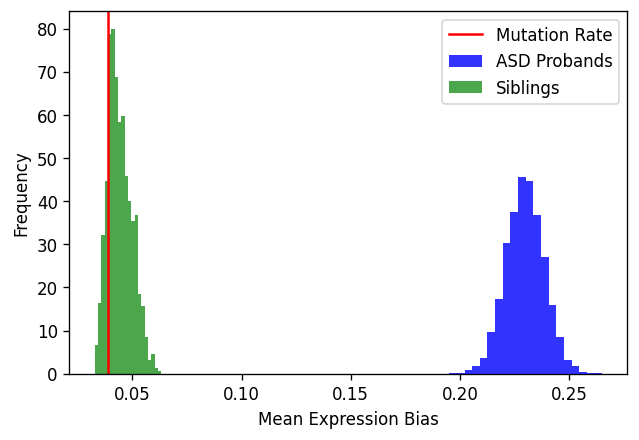

In [10]:
bias_bgmr = np.mean([abs(x) for x in BGMR_Meta_Spec["EFFECT"].values])
fig, ax = plt.subplots(dpi=120)
ax.hist(biases, density=True, bins=20, label = "ASD Probands", color="blue", alpha=0.8)
ax.hist(biases_sib_boot, density=True, bins=20, label = "Siblings", color="green", alpha=0.7)
ax.axvline(x=bias_bgmr, c="red", label="Mutation Rate")
plt.legend()
plt.xlabel("Mean Expression Bias")
plt.ylabel("Frequency")

###### bias_bgmr

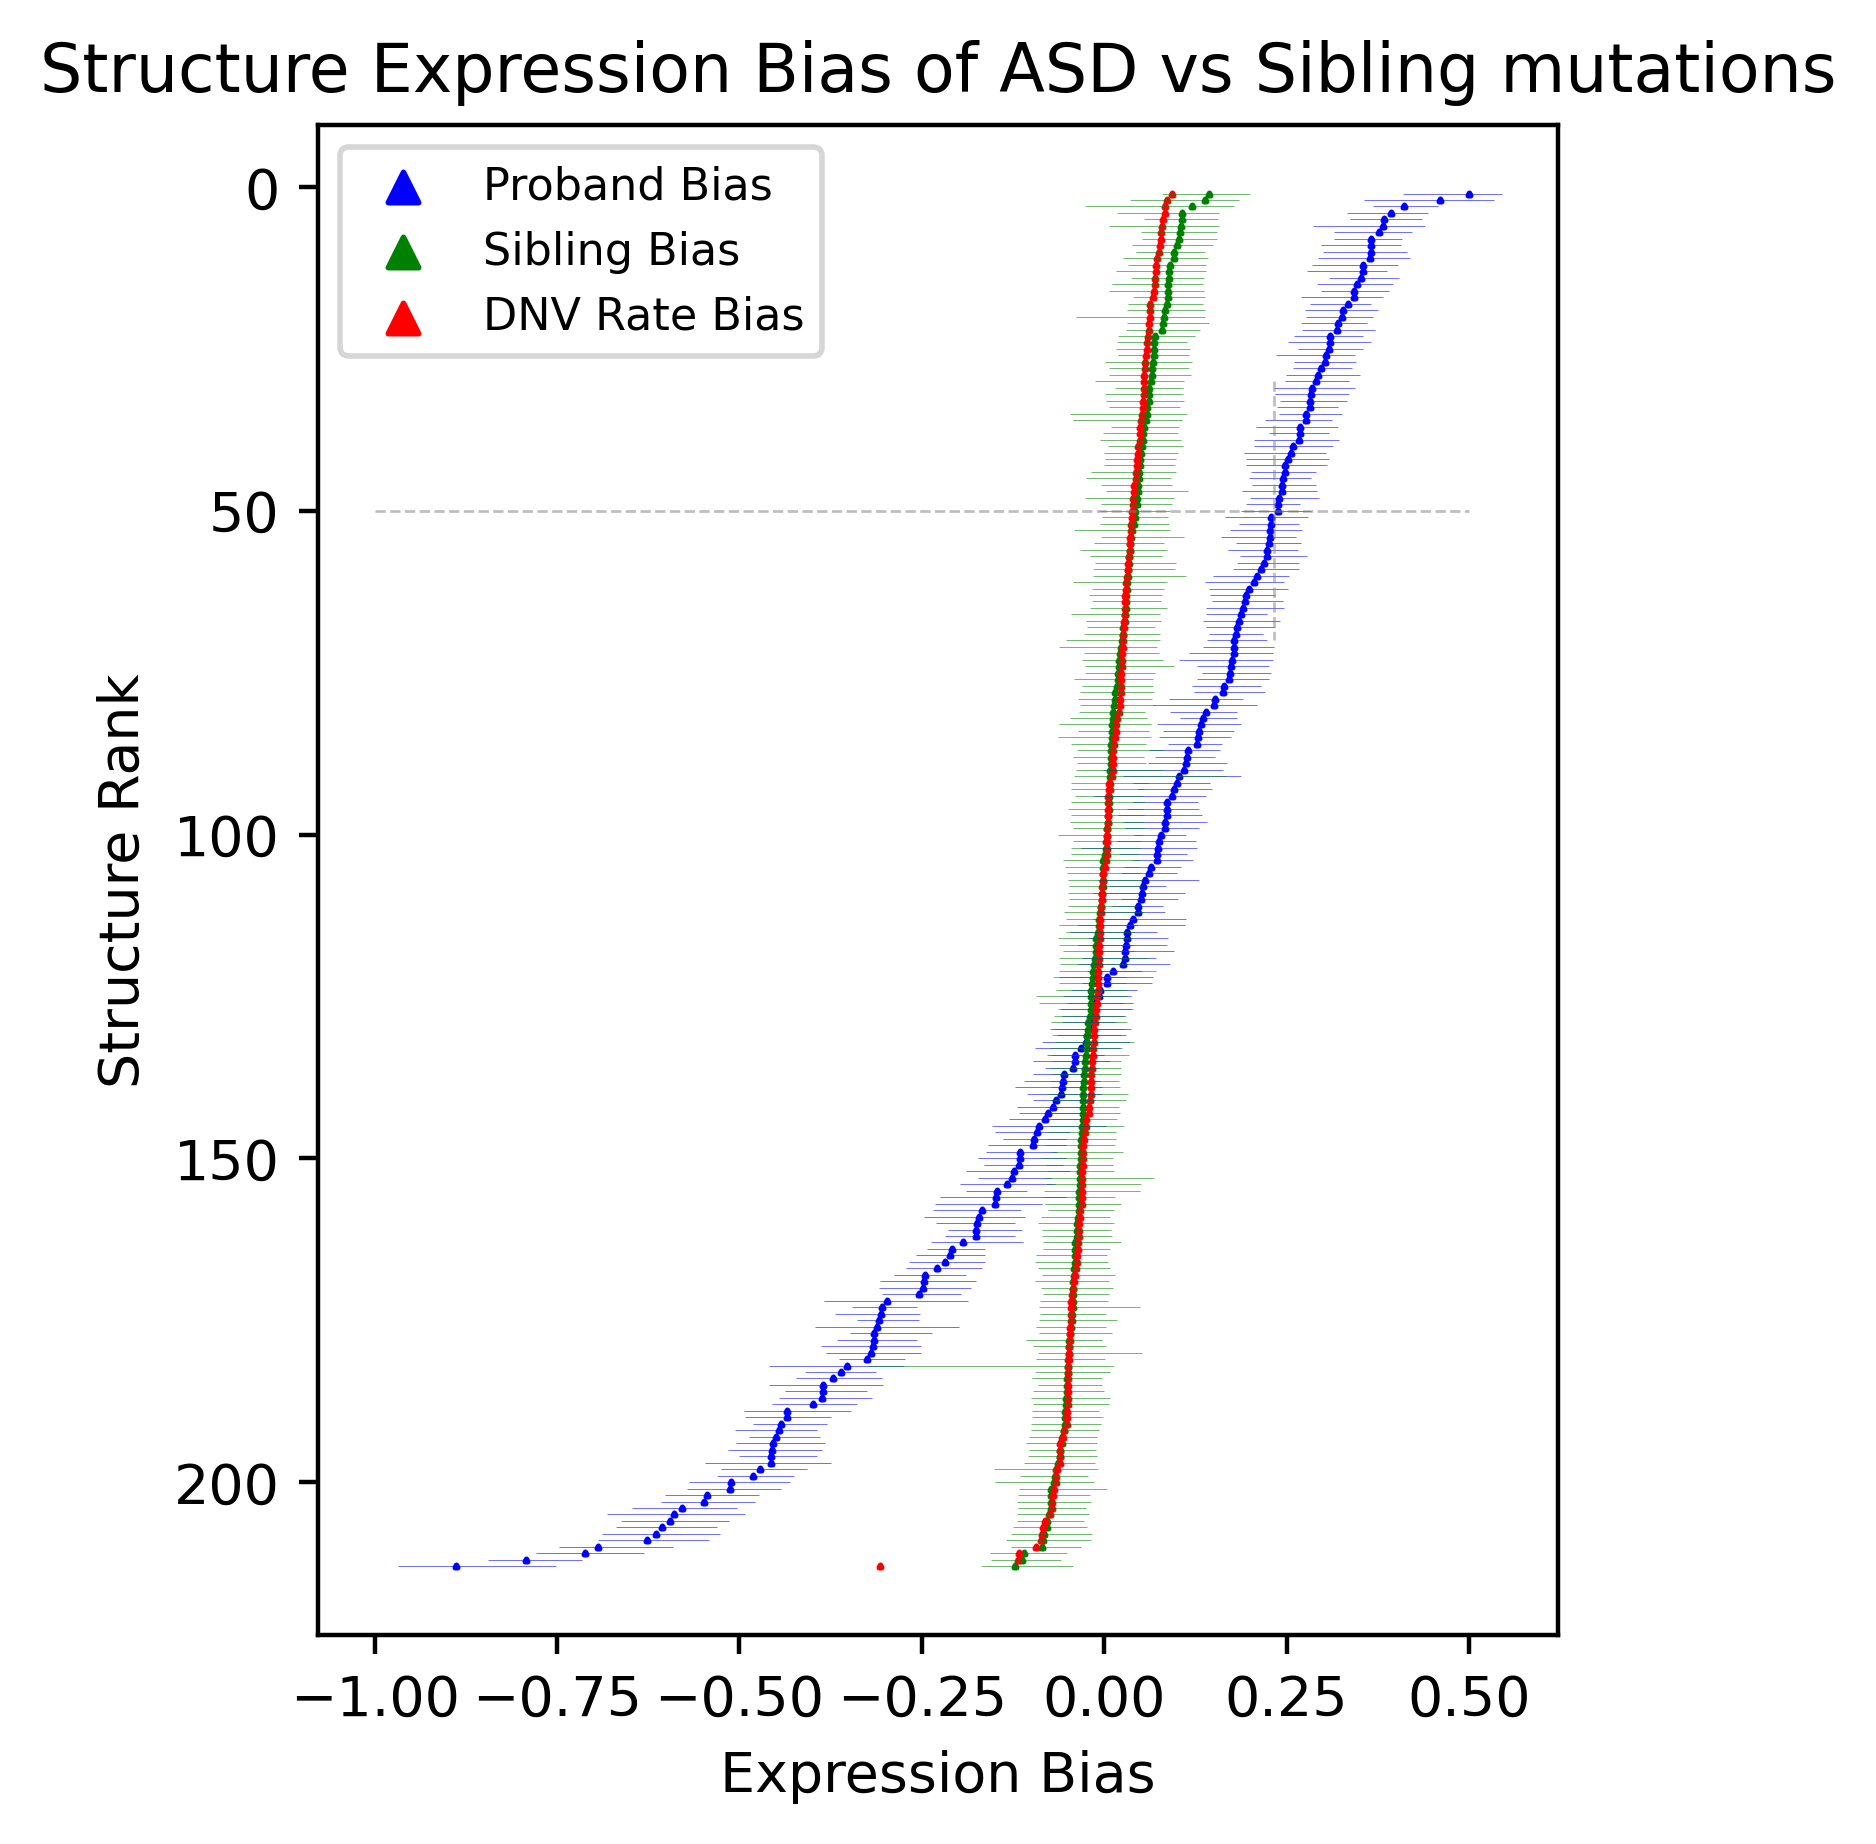

In [24]:
fig, ax = plt.subplots(figsize=(4, 5), dpi=400)
for i, (STR, STR_bias) in enumerate(sorted(ASD_STR_Biases.items(), key=lambda x:x[1].Rank)):
    upper, lower = STR_bias.GetCI(0.95)
    ax.hlines(i+1, lower, upper, color = "blue", lw=0.1)
    x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="blue")
for i, (STR, STR_bias) in enumerate(sorted(Sib_STR_Biases.items(), key=lambda x:x[1].Rank)):
    upper, lower = STR_bias.GetCI(0.95)
    ax.hlines(i+1, lower, upper, color = "green", lw=0.1)
    x2 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="green")
    
x3 = ax.scatter(BGMR_Meta_Spec["EFFECT"].values, np.arange(1, 214, 1), color="red", s=0.2, marker="^")
    
plt.gca().invert_yaxis()
lgnd = ax.legend([x1, x2, x3], ["Proband Bias", "Sibling Bias", "DNV Rate Bias"], prop={'size': 8})
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]

ax.hlines(xmin=-1, xmax=0.5, y=50, ls="--", color="grey", alpha=0.5, lw=0.5)
ax.vlines(ymin =30 , ymax = 70, x=0.232, ls="--", color="grey", alpha=0.5, lw=0.5)

plt.title("Structure Expression Bias of ASD vs Sibling mutations")
plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.savefig("figs/ExpBias.pdf")

In [28]:
biases_match_rank = {}
biases_match_STR = {}
asd_boot_dir = "dat/cont.bias/"
for file in os.listdir(asd_boot_dir):
    print(asd_boot_dir+file)
    df = pd.read_csv(asd_boot_dir+file, index_col="STR")
    for STR, row in df.iterrows():
        if STR not in biases_match_STR:
            biases_match_STR[STR] = []
        biases_match_STR[STR].append(row["EFFECT"])
        if row["Rank"] not in biases_match_rank:
            biases_match_rank[row["Rank"]] = []
        biases_match_rank[row["Rank"]].append(row["EFFECT"])

dat/cont.bias/ASD.MetaMatch.Spec.bias.0.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.1.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.10.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.100.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.101.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.102.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.103.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.104.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.105.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.106.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.107.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.108.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.109.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.11.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.110.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.111.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.112.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.113.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.114.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.115.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.116.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.11

dat/cont.bias/ASD.MetaMatch.Spec.bias.267.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.268.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.269.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.27.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.270.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.271.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.272.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.273.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.274.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.275.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.276.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.277.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.278.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.279.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.28.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.280.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.281.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.282.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.283.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.284.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.285.csv
dat/cont.bias/ASD.MetaMatch.Spec.bia

dat/cont.bias/ASD.MetaMatch.Spec.bias.438.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.439.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.44.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.440.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.441.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.442.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.443.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.444.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.445.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.446.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.447.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.448.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.449.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.45.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.450.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.451.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.452.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.453.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.454.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.455.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.456.csv
dat/cont.bias/ASD.MetaMatch.Spec.bia

dat/cont.bias/ASD.MetaMatch.Spec.bias.600.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.601.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.602.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.603.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.604.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.605.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.606.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.607.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.608.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.609.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.61.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.610.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.611.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.612.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.613.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.614.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.615.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.616.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.617.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.618.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.619.csv
dat/cont.bias/ASD.MetaMatch.Spec.bi

dat/cont.bias/ASD.MetaMatch.Spec.bias.767.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.768.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.769.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.77.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.770.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.771.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.772.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.773.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.774.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.775.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.776.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.777.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.778.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.779.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.78.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.780.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.781.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.782.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.783.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.784.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.785.csv
dat/cont.bias/ASD.MetaMatch.Spec.bia

dat/cont.bias/ASD.MetaMatch.Spec.bias.93.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.930.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.931.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.932.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.933.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.934.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.935.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.936.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.937.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.938.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.939.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.94.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.940.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.941.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.942.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.943.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.944.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.945.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.946.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.947.csv
dat/cont.bias/ASD.MetaMatch.Spec.bias.948.csv
dat/cont.bias/ASD.MetaMatch.Spec.bia

In [68]:
biases_match_rank_z1 = {}
biases_match_STR_z1 = {}
asd_boot_dir = "dat/cont.bias.z1/"
for file in os.listdir(asd_boot_dir):
    df = pd.read_csv(asd_boot_dir+file, index_col="STR")
    for STR, row in df.iterrows():
        if STR not in biases_match_STR_z1:
            biases_match_STR_z1[STR] = []
        biases_match_STR_z1[STR].append(row["EFFECT"])
        if row["Rank"] not in biases_match_rank_z1:
            biases_match_rank_z1[row["Rank"]] = []
        biases_match_rank_z1[row["Rank"]].append(row["EFFECT"])

In [70]:
biases_z1, biases_z2 = [], []
asd_boot_dir = "dat/cont.bias.z1/"
for file in os.listdir(asd_boot_dir):
    df = pd.read_csv(asd_boot_dir+file, index_col="STR")
    biases_z1.append(np.mean([abs(x) for x in df["EFFECT"].values]))
    
asd_boot_dir = "dat/cont.bias/"
for file in os.listdir(asd_boot_dir):
    df = pd.read_csv(asd_boot_dir+file, index_col="STR")
    biases_z2.append(np.mean([abs(x) for x in df["EFFECT"].values]))

In [80]:
biases_sib_rank_z2 = {}
biases_sib_STR_z2 = {}
asd_boot_dir = "dat/cont.sib.bias/"
for file in os.listdir(asd_boot_dir):
    df = pd.read_csv(asd_boot_dir+file, index_col="STR")
    for STR, row in df.iterrows():
        if STR not in biases_sib_STR_z2:
            biases_sib_STR_z2[STR] = []
        biases_sib_STR_z2[STR].append(row["EFFECT"])
        if row["Rank"] not in biases_sib_rank_z2:
            biases_sib_rank_z2[row["Rank"]] = []
        biases_sib_rank_z2[row["Rank"]].append(row["EFFECT"])


In [73]:
mannwhitneyu(biases_z1, biases_z2)

MannwhitneyuResult(statistic=367900.0, pvalue=7.289043394651593e-25)

Text(0, 0.5, 'Frequency')

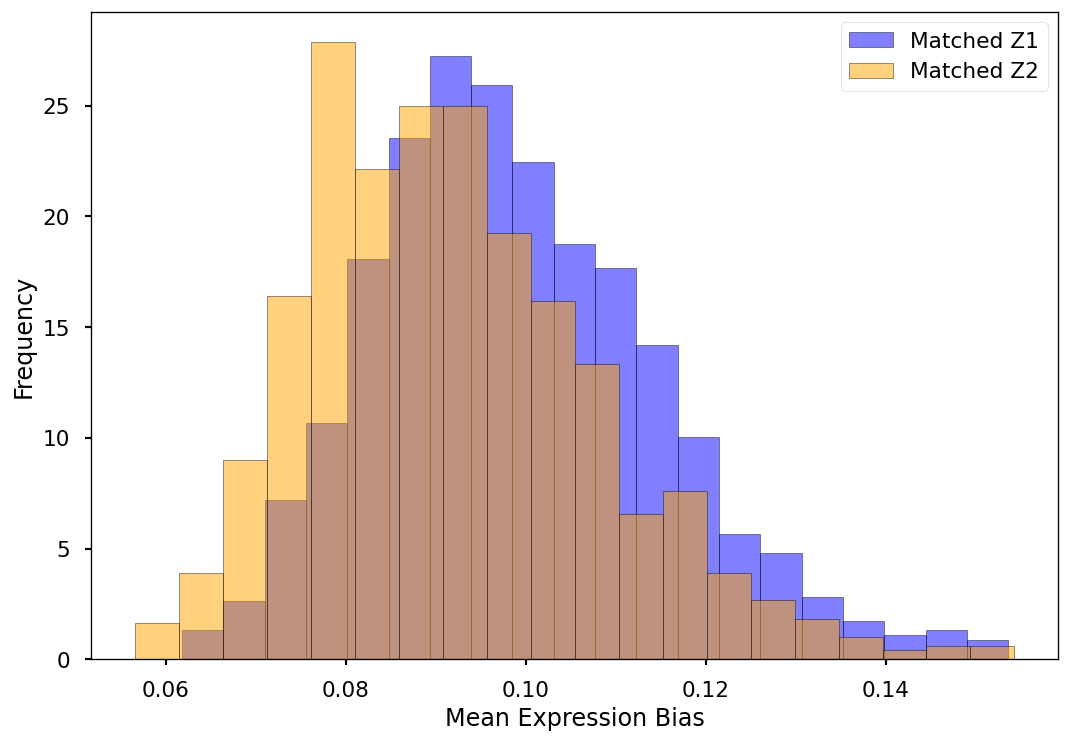

In [79]:
plt.style.use('seaborn-talk') # nice and clean grid
bias_bgmr = np.mean([abs(x) for x in BGMR_Meta_Spec["EFFECT"].values])
fig, ax = plt.subplots(dpi=120)
ax.hist(biases_z1, density=True, bins=20, label = "Matched Z1", color="blue", alpha=0.5,
       edgecolor="black", linewidth=0.5)
ax.hist(biases_z2, density=True, bins=20, label = "Matched Z2", color="orange", alpha=0.5,
       edgecolor="black", linewidth=0.5)
plt.legend()
plt.xlabel("Mean Expression Bias")
plt.ylabel("Frequency")

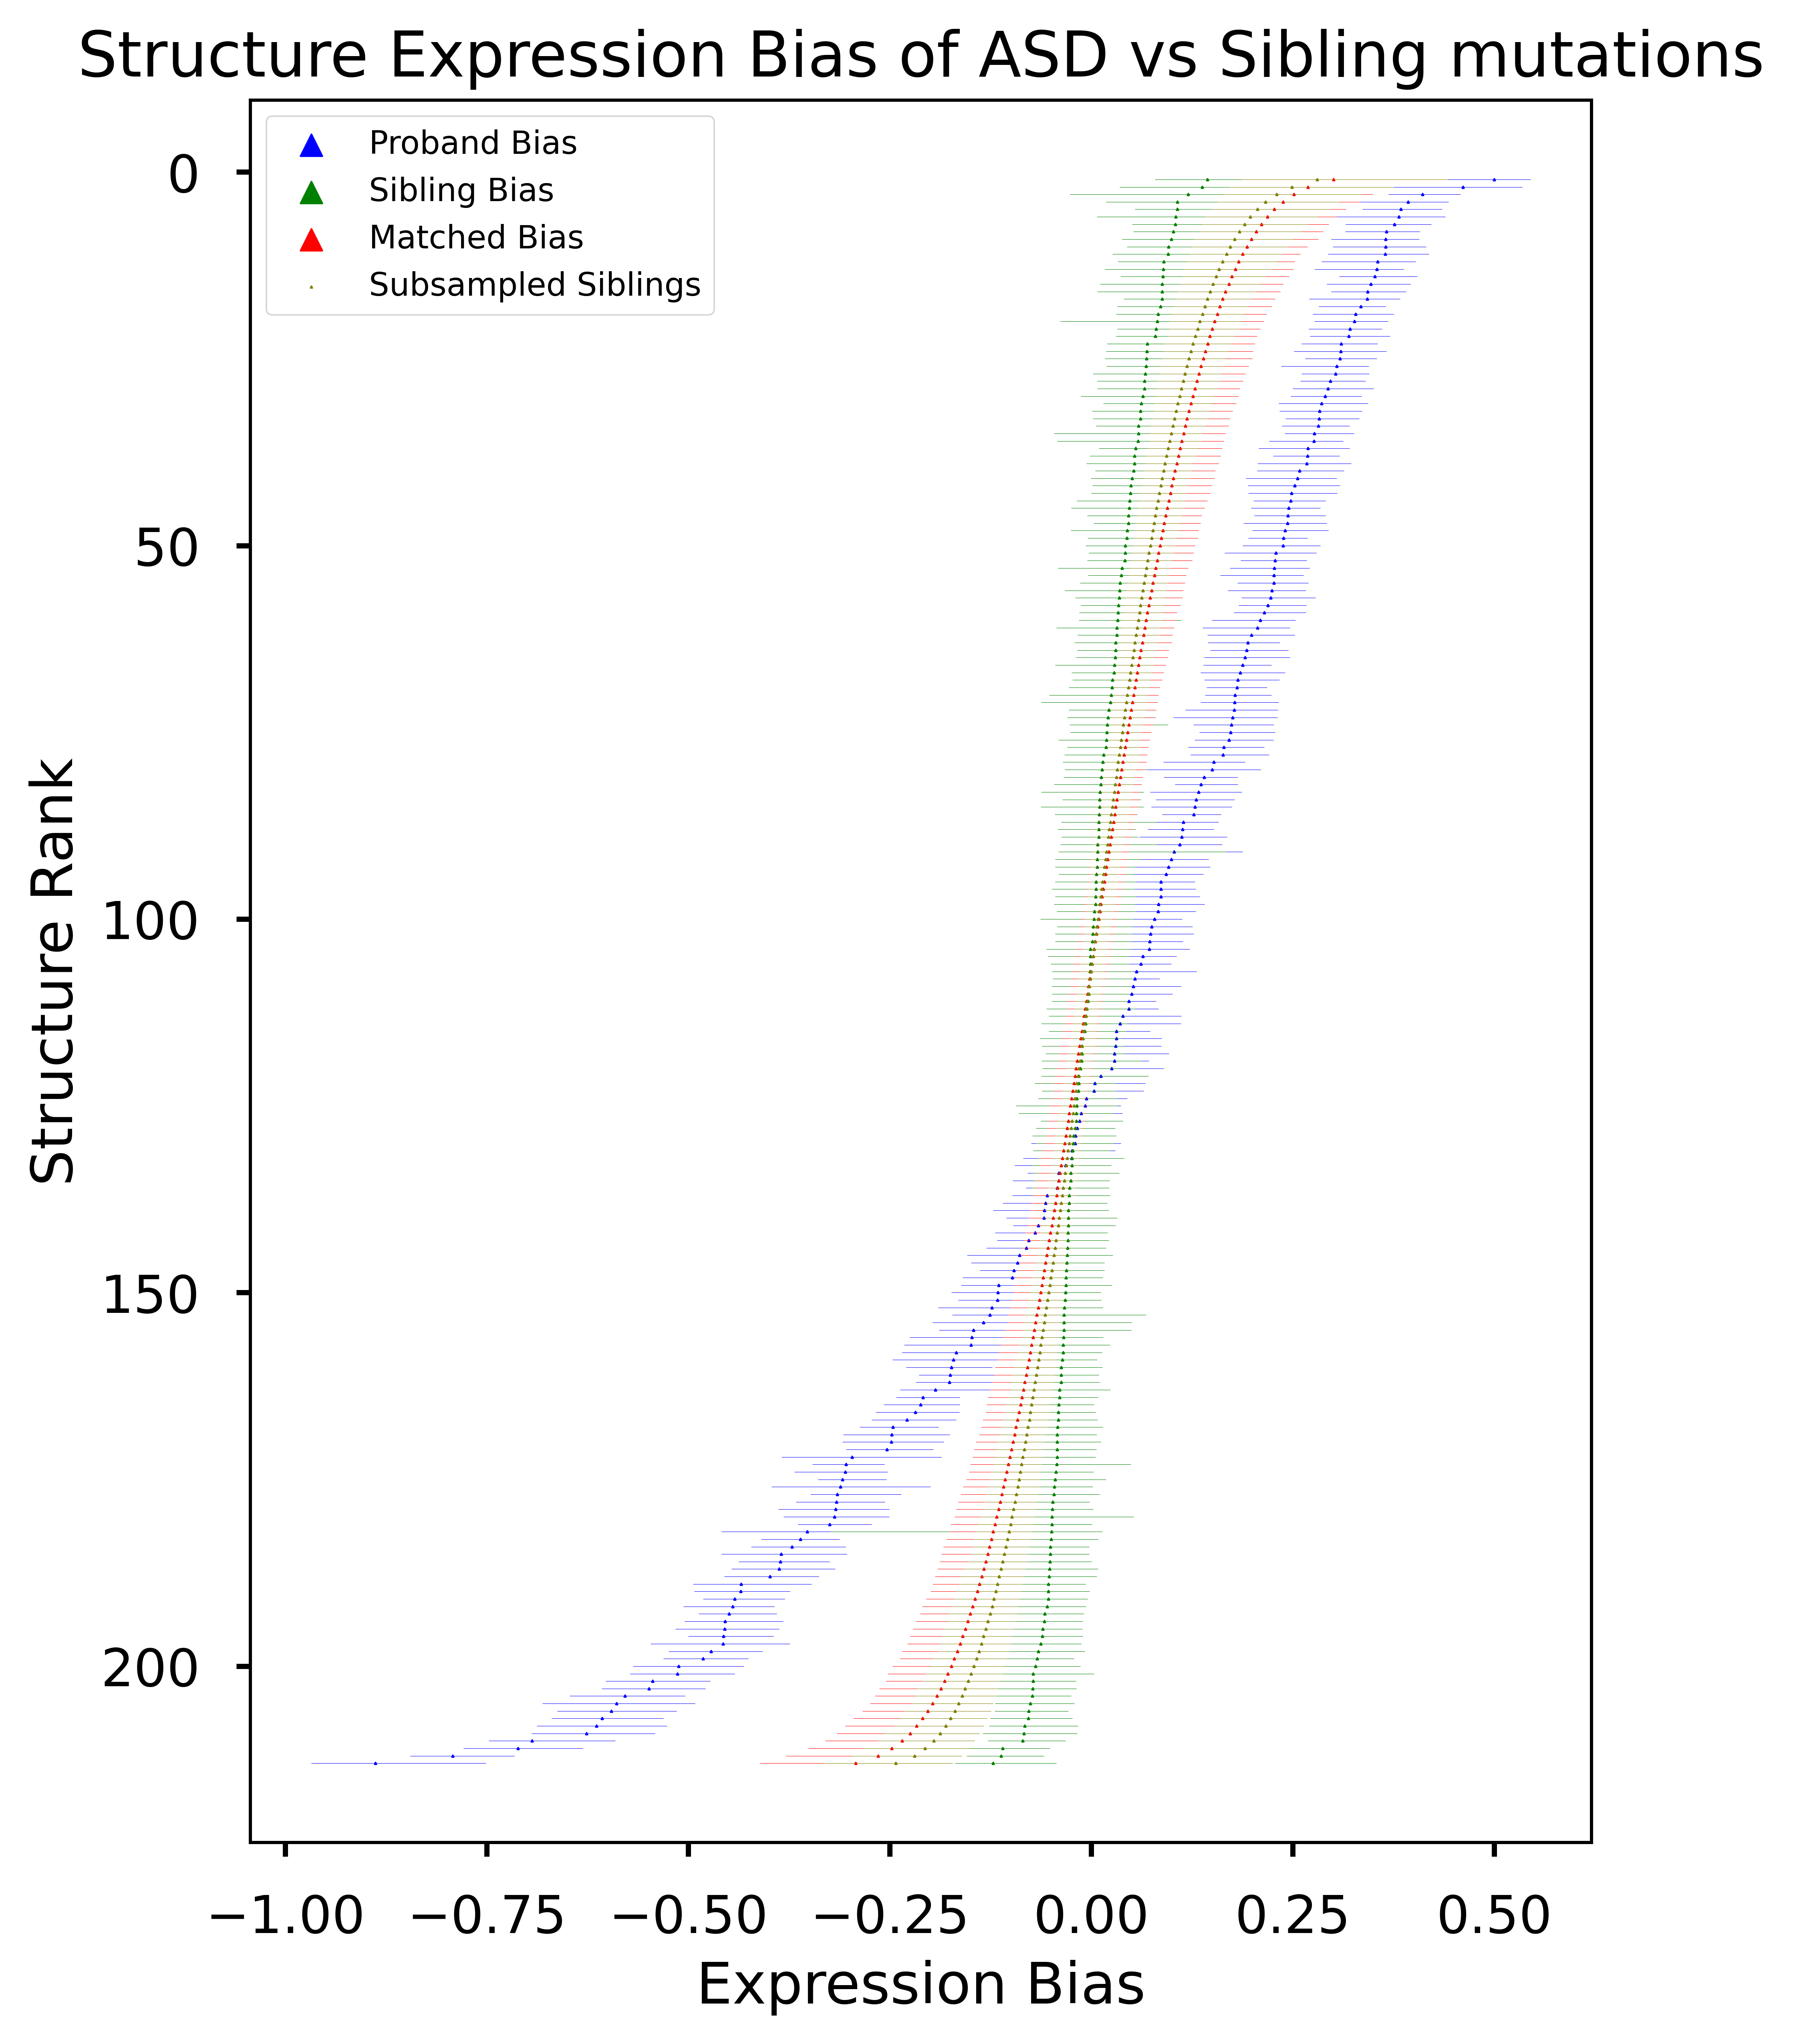

In [86]:
fig, ax = plt.subplots(figsize=(6, 8), dpi=720)
for i, (STR, STR_bias) in enumerate(sorted(ASD_STR_Biases.items(), key=lambda x:x[1].Rank)):
    upper, lower = STR_bias.GetCI(0.95)
    ax.hlines(i+1, lower, upper, color = "blue", lw=0.1)
    x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="blue")
for i, (STR, STR_bias) in enumerate(sorted(Sib_STR_Biases.items(), key=lambda x:x[1].Rank)):
    upper, lower = STR_bias.GetCI(0.95)
    ax.hlines(i+1, lower, upper, color = "green", lw=0.1)
    x2 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="green")
    
for i, (Rank, data) in enumerate(sorted(biases_match_rank.items(), key=lambda x:x[0])):
    upper, lower = CI(data, 0.95)
    ax.hlines(i+1, lower, upper, color = "red", lw=0.1)
    x3 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="red")
    
for i, (Rank, data) in enumerate(sorted(biases_sib_rank_z2.items(), key=lambda x:x[0])):
    upper, lower = CI(data, 0.95)
    ax.hlines(i+1, lower, upper, color = "olive", lw=0.1)
    x4 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="olive")
    
#x3 = ax.scatter(BGMR_Meta_Spec["EFFECT"].values, np.arange(1, 214, 1), color="red", s=0.2, marker="^")
    
plt.gca().invert_yaxis()
lgnd = ax.legend([x1, x2, x3, x4], 
                 ["Proband Bias", "Sibling Bias", "Matched Bias", "Subsampled Siblings"], 
                 prop={'size': 8})
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]

#ax.hlines(xmin=-1, xmax=0.5, y=50, ls="--", color="grey", alpha=0.5, lw=0.5)
#ax.vlines(ymin =30 , ymax = 70, x=0.232, ls="--", color="grey", alpha=0.5, lw=0.5)

plt.title("Structure Expression Bias of ASD vs Sibling mutations")
plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.savefig("figs/ExpBias_vs_Rank_match_sib.pdf")

##### Test bias significance

In [128]:
asd_boot_dir = "dat/cont.bias/"
match_dfs = []
for file in os.listdir(asd_boot_dir):
    df = pd.read_csv(asd_boot_dir+file, index_col="STR")
    match_dfs.append(df)
    
sib_sub_dir = "dat/cont.sib.bias/"
sib_dfs = []
for file in os.listdir(sib_sub_dir):
    df = pd.read_csv(sib_sub_dir+file, index_col="STR")
    sib_dfs.append(df)

In [120]:
def getBiasesBySTR(STR, dfs):
    biases = []
    for df in dfs:
        bias = df.loc[STR, "EFFECT"]
        biases.append(bias)
    biases = np.array(biases)
    return biases
def getBiasesByRank(Rank, dfs):
    biases = []
    for df in dfs:
        bias = df.loc[Rank, "EFFECT"]
        biases.append(bias)
    biases = np.array(biases)
    return biases

In [136]:
# ASD-match
for STR, row in SparkMetaBias.iterrows():
    mat_bias = getBiasesBySTR(STR, match_dfs)
    Z, P = GetPermutationP(mat_bias, row["EFFECT"])
    sib_bias = getBiasesBySTR(STR, sib_dfs)
    Z2, P2 = mannwhitneyu(sib_bias, mat_bias)
    print("%d %s %.3f %.3e" % (row["Rank"], STR, row["EFFECT"], P))
    print("%.3f %.3f %.3f %.3e"%(np.mean(mat_bias), np.mean(sib_bias), 
              np.mean(mat_bias) - np.mean(sib_bias), P2))
    SparkMetaBias.loc[STR, "Pvalue"] = P

1 Dentate_gyrus 0.467 9.990e-04
-0.003 0.046 -0.048 1.247e-21
2 Field_CA1 0.449 9.990e-04
0.001 0.018 -0.017 1.754e-04
3 Orbital_area_lateral_part 0.441 9.990e-04
-0.002 -0.008 0.006 8.383e-02
4 Prelimbic_area 0.399 9.990e-04
0.007 0.029 -0.021 4.965e-06
5 Orbital_area_ventrolateral_part 0.391 9.990e-04
-0.002 -0.004 0.002 2.858e-01
6 Field_CA2 0.390 1.998e-03
-0.003 0.008 -0.011 1.426e-02
7 Infralimbic_area 0.387 9.990e-04
0.005 0.034 -0.029 1.992e-10
8 Dorsal_peduncular_area 0.386 9.990e-04
0.006 0.041 -0.035 1.094e-13
9 Nucleus_accumbens 0.382 9.990e-04
0.005 0.006 -0.001 2.880e-01
10 Lateral_amygdalar_nucleus 0.375 9.990e-04
0.001 -0.006 0.007 4.915e-02
11 Field_CA3 0.371 2.997e-03
-0.003 0.051 -0.053 8.354e-27
12 Subiculum_ventral_part 0.364 9.990e-04
0.002 -0.010 0.012 7.877e-03
13 Anterior_olfactory_nucleus 0.352 9.990e-04
-0.002 -0.030 0.027 1.021e-08
14 Basomedial_amygdalar_nucleus 0.347 9.990e-04
-0.003 -0.035 0.032 1.215e-13
15 Lateral_posterior_nucleus_of_the_thalamus 0.345

111 Lateral_habenula 0.041 3.526e-01
0.000 0.102 -0.101 6.609e-91
112 Anterior_hypothalamic_nucleus 0.040 3.936e-01
0.004 -0.035 0.039 2.972e-18
113 Lateral_preoptic_area 0.039 3.706e-01
0.001 -0.092 0.093 1.696e-77
114 Triangular_nucleus_of_septum 0.034 3.706e-01
-0.003 -0.017 0.014 9.853e-04
115 Periventricular_hypothalamic_nucleus_preoptic_part 0.033 4.126e-01
0.003 -0.007 0.010 1.442e-02
116 Medial_amygdalar_nucleus 0.029 4.186e-01
0.005 -0.014 0.019 1.895e-06
117 Medial_preoptic_nucleus 0.029 4.136e-01
0.002 -0.041 0.044 9.101e-22
118 Culmen 0.026 4.096e-01
-0.000 0.012 -0.012 2.254e-03
119 Subparaventricular_zone 0.025 4.376e-01
0.003 -0.005 0.008 1.485e-02
120 Entorhinal_area_medial_part_dorsal_zone 0.022 4.096e-01
0.002 -0.010 0.012 9.017e-03
121 Retrosplenial_area_ventral_part 0.021 4.116e-01
-0.002 0.045 -0.047 6.496e-25
122 Medial_geniculate_complex_dorsal_part 0.017 4.336e-01
0.000 0.089 -0.089 3.597e-67
123 Subparafascicular_nucleus_parvicellular_part 0.016 4.166e-01
-0.00

In [139]:
reg, corrP = stats.multitest.fdrcorrection(SparkMetaBias["Pvalue"], alpha=0.05)

In [141]:
SparkMetaBias["FDR"] = corrP

In [142]:
SparkMetaBias.to_csv("dat/bias2/SparkMetaBias.addP.csv")

In [132]:
asd_boot_dir = "dat/cont.bias/"
match_dfs_byrank = []
for file in os.listdir(asd_boot_dir):
    df = pd.read_csv(asd_boot_dir+file, index_col="Rank")
    match_dfs_byrank.append(df)
    
sib_boot_dir = "dat/cont.sib.bias/"
sib_dfs_byrank = []
for file in os.listdir(sib_boot_dir):
    df = pd.read_csv(sib_boot_dir+file, index_col="Rank")
    sib_dfs_byrank.append(df)

In [134]:
# ASD-match
for Rank, row in SparkMetaBias.iterrows():
    Rank = row["Rank"]
    mat_bias = getBiasesByRank(Rank, match_dfs_byrank)
    Z, P = GetPermutationP(mat_bias, row["EFFECT"])
    sib_bias = getBiasesByRank(Rank, sib_dfs_byrank)
    Z2, P2 = mannwhitneyu(sib_bias, mat_bias)
    print(Rank, P)
    print(P2)

1.0 0.005994005994006013
7.336444258565839e-19
2.0 0.0009990009990009652
1.2723065530339286e-23
3.0 0.0009990009990009652
1.0932848252732847e-28
4.0 0.0019980019980020414
2.3070545694396847e-33
5.0 0.0019980019980020414
3.901228941671132e-35
6.0 0.0019980019980020414
1.022525586484493e-36
7.0 0.0019980019980020414
1.0958456286945521e-38
8.0 0.0019980019980020414
5.9111278148409695e-40
9.0 0.0019980019980020414
1.9449797284674112e-42
10.0 0.0009990009990009652
1.224203181050638e-44
11.0 0.0009990009990009652
1.1558963393032666e-43
12.0 0.0019980019980020414
6.4256190887518784e-46
13.0 0.0019980019980020414
1.3908825215360514e-46
14.0 0.0009990009990009652
1.3481854098665113e-47
15.0 0.0009990009990009652
4.780914357371504e-49
16.0 0.0009990009990009652
1.2221882234529245e-48
17.0 0.0009990009990009652
2.7505354585019994e-48
18.0 0.0009990009990009652
7.441683421973783e-49
19.0 0.0009990009990009652
6.323450065274066e-50
20.0 0.0009990009990009652
1.6856978186130695e-51
21.0 0.0009990009

177.0 1.0
1.7933443888278386e-83
178.0 1.0
9.820282876854713e-83
179.0 1.0
4.61594957391749e-83
180.0 1.0
6.1332852250718295e-83
181.0 1.0
1.5620899387062405e-82
182.0 1.0
1.7391567661777845e-82
183.0 1.0
5.751309467887408e-83
184.0 1.0
2.1925282440866503e-83
185.0 1.0
6.982188507412712e-84
186.0 1.0
1.1096944982390642e-84
187.0 1.0
1.2571196510894436e-85
188.0 1.0
1.9446955945879273e-86
189.0 1.0
1.6710937806656597e-87
190.0 1.0
6.582522738667716e-90
191.0 1.0
1.1512266825755972e-89
192.0 1.0
4.8457238627404826e-91
193.0 1.0
2.0735468706087475e-92
194.0 1.0
7.538901311956179e-91
195.0 1.0
6.256527156750912e-91
196.0 1.0
5.341841748765231e-90
197.0 1.0
3.8800847562378714e-90
198.0 1.0
6.876049531046133e-90
199.0 1.0
2.5583546198930442e-92
200.0 1.0
1.0006611559734525e-91
201.0 1.0
1.5570019028936717e-91
202.0 1.0
9.819358039534261e-92
203.0 1.0
2.542334065257441e-91
204.0 1.0
6.706005111315705e-96
205.0 1.0
1.3644036924687844e-97
206.0 1.0
2.2248765084478588e-98
207.0 1.0
2.69704842933

### Overlap with ASD top 50

In [38]:
# Overlap with real ASD top 50
SparkMetaBias = pd.read_csv("dat/Jon_data/Spark_Final_ExpBias.csv")
SparkMetaBias.columns = ["STR", "EFFECT", "Rank", "NGene"]
SparkMetaBias = SparkMetaBias.set_index("STR")
Spark_top_50 = SparkMetaBias.head(50).index.values

In [66]:
Overlap_top50_Match = []
A = set(Spark_top_50)
asd_boot_dir = "dat/cont.bias/"
count = 0
for file in os.listdir(asd_boot_dir):
    df = pd.read_csv(asd_boot_dir+file, index_col="STR")
    top50 = df.head(50).index.values
    B = set(top50)
    N_overlap = len(A.intersection(B))
    Overlap_top50_Match.append(N_overlap)
    if N_overlap > 25:
        count += 1
count

36

In [45]:
Overlap_top50_Sib = []
A = set(Spark_top_50)
B = set(Sib_Bias_spec.head(50).index.values)
print(len(A.intersection(B)))

9


In [57]:
overlap_random = []
for i in range(1000):
    rand50 = np.random.choice(SparkMetaBias.index.values, 50)
    B = set(rand50)
    overlap = len(A.intersection(B))
    overlap_random.append(overlap)

In [87]:
Overlap_top50_subsib = []
A = set(Spark_top_50)
asd_boot_dir = "dat/cont.sib.bias/"
count = 0
for file in os.listdir(asd_boot_dir):
    df = pd.read_csv(asd_boot_dir+file, index_col="STR")
    top50 = df.head(50).index.values
    B = set(top50)
    N_overlap = len(A.intersection(B))
    Overlap_top50_subsib.append(N_overlap)
    if N_overlap > 25:
        count += 1
count

12

In [149]:
gene = 27086
GeneDict = {gene:1}
Gene_Spec = AvgSTRZ_Weighted(ExpZscoreMat, GeneDict, Match_DF=Agg_Match, Method = 1,
                      csv_fil = "dat/bias2/Entrez.{}.Spec.bias.csv".format(gene))

In [143]:
Agg_Match = pd.read_csv("dat/Final_Spark_Meta.Matches.csv", index_col="GENE")
Spark_Meta = pd.read_excel("/Users/jiayao/Work/ASD_Circuits/dat/genes/asd/spark_Meta_top_genes.xlsx")


In [150]:
overlap_single_gene = []
for i, row in Spark_Meta.iterrows():
    try:
        gene = int(row["EntrezID"])
        df = pd.read_csv("dat/bias2/Entrez.{}.Spec.bias.csv".format(gene), index_col="STR")
    except:
        continue
    Mutcount = row["AutismMerged_LoF"] + row["AutismMerged_Dmis_REVEL0.5"]
    for xx in range(Mutcount):
        top50 = df.head(50).index.values
        B = set(top50)
        N_overlap = len(A.intersection(B))
        overlap_single_gene.append(N_overlap)

Text(0.5, 0, 'Number of top 50 overlap with ASD top 50')

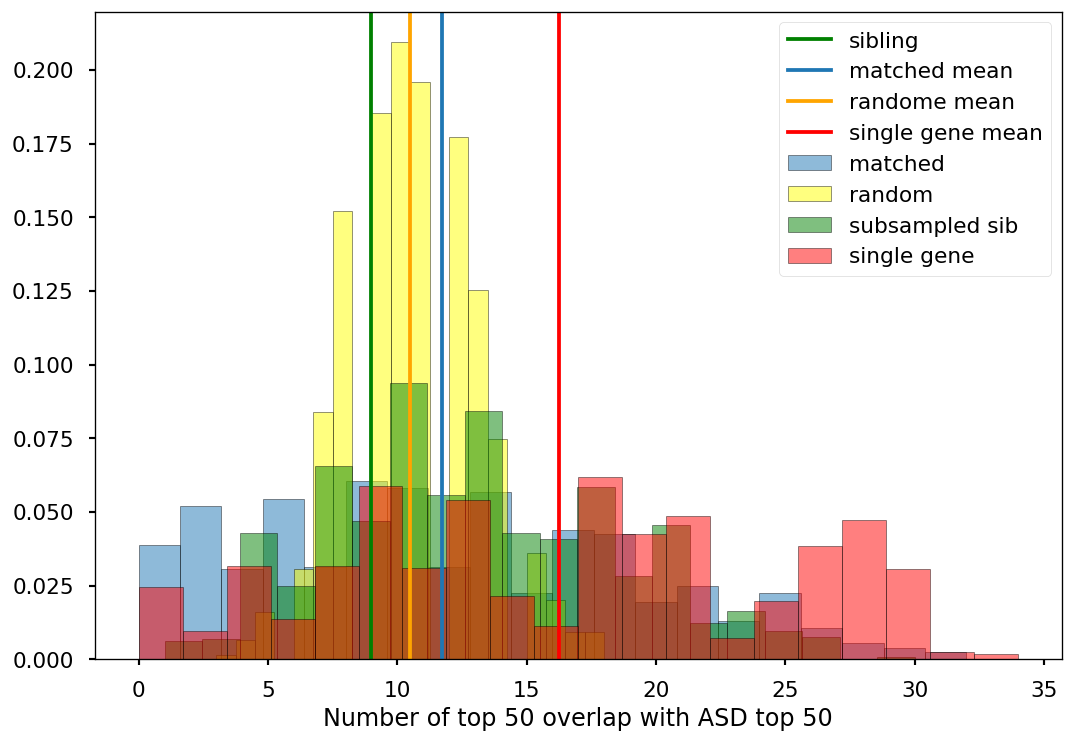

In [151]:
fig, ax = plt.subplots(dpi=120)
plt.style.use('seaborn-talk') # nice and clean grid
ax.hist(Overlap_top50_Match, edgecolor='black', density=1, bins=20,
                    alpha=0.5, linewidth=0.5, label="matched")
ax.hist(overlap_random, edgecolor='black', density=1, color="yellow", bins=20,
                    alpha=0.5, linewidth=0.5, label="random")
ax.hist(Overlap_top50_subsib, edgecolor='black', density=1, color="green" , bins=20,
                    alpha=0.5, linewidth=0.5, label="subsampled sib")
ax.hist(overlap_single_gene, edgecolor='black', density=1, color="red", bins=20,
                    alpha=0.5, linewidth=0.5, label="single gene")
ax.axvline(x=9, label="sibling", color="green")
ax.axvline(x=np.mean(Overlap_top50_Match), label="matched mean")
ax.axvline(x=np.mean(overlap_random), label="randome mean", color="orange")
ax.axvline(x=np.mean(overlap_single_gene), label="single gene mean", color="red")
ax.legend()
ax.set_xlabel("Number of top 50 overlap with ASD top 50")

In [224]:
## check single gene results are correct
Entrez, SingleGeneDFs = [], []
for i, row in Spark_Meta.iterrows():
    try:
        gene = int(row["EntrezID"])
        df = pd.read_csv("dat/bias2/IndvGene/Entrez.{}.Spec.bias.csv".format(gene), index_col="STR")
        if not df.head(5)["EFFECT"].mean() < 1e5:
            print("Bad Gene:", row["EntrezID"])
        SingleGeneDFs.append(df)
        Entrez.append(gene)
    except:
        #print("Don't have file", row["EntrezID"])
        continue

In [230]:
ALL_STRs = ExpMat.columns.values
dat=[]
for gene, DF in zip(Entrez, SingleGeneDFs):
    dat_row = []
    for STR in ALL_STRs:
        dat_row.append(DF.loc[STR, "EFFECT"])
    dat.append(dat_row)
df = pd.DataFrame(data=dat, index=Entrez, columns=ALL_STRs)
df.to_csv("dat/bias2/Indv.gene.z2.csv")

In [231]:
df

,Anterior_amygdalar_area,Anterior_cingulate_area_dorsal_part,Anterior_cingulate_area_ventral_part,Nucleus_accumbens,Anterodorsal_nucleus,Anterior_hypothalamic_nucleus,Agranular_insular_area_dorsal_part,Agranular_insular_area_posterior_part,Agranular_insular_area_ventral_part,Nucleus_ambiguus,...,Primary_visual_area,Posterolateral_visual_area,posteromedial_visual_area,Ventral_medial_nucleus_of_the_thalamus,Ventromedial_hypothalamic_nucleus,Ventral_posterolateral_nucleus_of_the_thalamus,Ventral_posteromedial_nucleus_of_the_thalamus,Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part,Ventral_tegmental_area,Hypoglossal_nucleus
4204,1.165553,0.475367,0.827645,0.740878,-1.219865,1.461522,-0.705069,0.061696,-0.050718,-0.569687,...,-1.448739,-1.052724,-1.163345,0.189828,0.178210,-0.808990,-0.370592,-0.836916,0.810837,-0.413514
6326,-0.287678,1.450627,1.338073,0.927063,0.107664,0.628024,1.141213,1.458050,1.311671,-1.260151,...,1.006595,0.995839,0.904844,0.411941,0.071571,-1.924508,-1.667219,0.124141,-0.162924,-0.219890
5728,0.723467,1.348543,1.407886,0.846651,0.365232,0.619354,0.704993,1.385910,0.658838,-0.247506,...,1.095568,1.046556,0.838795,0.685612,1.054288,0.025839,-0.263722,0.674901,-0.281217,-2.051614
1106,-0.427746,-1.456459,-1.276253,-0.788150,0.706251,0.876849,-1.431029,-0.506015,-0.858111,-1.090789,...,-0.143928,0.202642,0.070381,0.535934,0.960071,0.205857,-0.161132,-0.321818,1.416015,-1.147547
1859,0.293521,-0.459538,0.098642,-0.714065,0.524008,0.684977,-0.858581,-0.569642,-0.589198,-0.239364,...,-1.826570,-2.352819,-2.396340,-0.584521,2.473713,0.297504,-0.149756,-0.645344,-0.321584,0.701550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7403,-0.551289,-0.800876,-0.808399,0.364733,2.021956,0.652294,-0.767271,-0.850448,-1.234021,0.266817,...,-0.789296,-0.255955,-0.861925,1.714050,1.001771,-1.094685,-0.731630,0.901138,0.860699,-1.477869
3155,-1.380474,0.124528,-0.558219,-1.006544,0.524982,-1.469392,0.485633,-0.192480,0.986147,0.157934,...,2.207542,1.278213,2.368540,-1.492804,-0.524991,-0.809863,-0.747214,-1.035111,-1.426388,0.762561
3096,0.153303,2.016262,2.501402,0.598417,-1.155858,-0.034488,1.534091,1.636210,1.561739,-0.458075,...,0.798638,0.441651,1.110873,1.265278,-0.467300,0.952387,0.638574,0.858824,0.514798,-1.066555
125228,0.777732,-0.646238,0.027147,0.336075,0.113278,0.863866,-0.406986,-0.611442,-0.380783,1.328376,...,-1.880255,-1.885947,-1.454537,0.026054,0.331295,-0.471286,-0.401345,-0.452631,1.113647,0.265179


In [202]:
def getoverlapN(SingleGeneDFs, topN, setA):
    overlap_single_gene = []
    for DF in SingleGeneDFs:
        topXXX = DF.head(topN).index.values
        setB = set(topXXX)
        overlap_single_gene.append(len(setA.intersection(setB)))
    return np.mean(overlap_single_gene)

def getoverlap_random(topN, setA, AllSTRs, Ntrails=10000):
    overlap_random = []
    for i in range(1000):
        random.shuffle(AllSTRs)
        topXXX = AllSTRs[:topN]
        B = set(topXXX)
        overlap = len(setA.intersection(B))
        overlap_random.append(overlap)
    return np.mean(overlap_random)

In [210]:
# Enrichment of top N for single gene hit on Circuit
Circuit_STRs = pd.read_csv("dat/Circuit_GN_42.csv")["STR"].values
setA = set(Circuit_STRs)
topN_slices = list(range(1,20)) + [25,30,35,40,45,50,70,90,110,150,200,213]

SingleASDGeneCircuitOverlap = []
for topN in topN_slices:
    tmp = getoverlapN(SingleGeneDFs, topN, setA)
    SingleASDGeneCircuitOverlap.append(tmp)
    
RandomCircuitOverlap = []
for topN in topN_slices:
    tmp = getoverlap_random(topN, setA, SparkMetaBias.index.values)
    RandomCircuitOverlap.append(tmp)
    
SingleASDGeneCircuitOverlap = np.array(SingleASDGeneCircuitOverlap)
RandomCircuitOverlap = np.array(RandomCircuitOverlap)

In [211]:
print(SingleASDGeneCircuitOverlap[-1], RandomCircuitOverlap[-1])

43.0 43.0


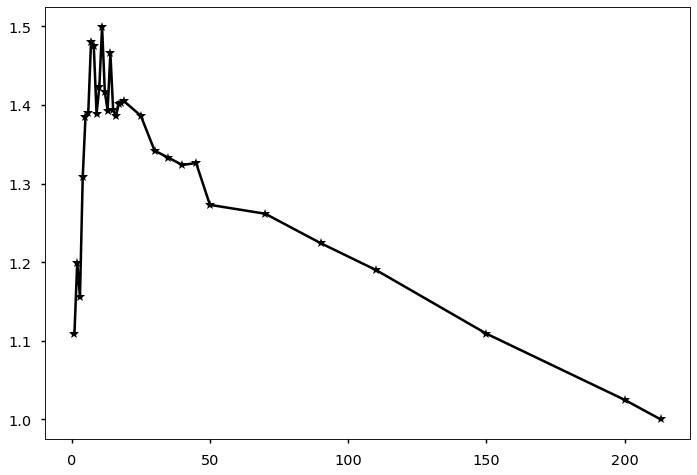

In [214]:
fig, ax = plt.subplots()
ax.plot(topN_slices, SingleASDGeneCircuitOverlap/RandomCircuitOverlap, 
       marker="*", color="black")
#ax.set_xlim(0,50)

In [157]:
16/11

1.4545454545454546

### 2. Bootstrapped top N Cohesiveness

In [561]:
g = LoadConnectome2()
EdgeWeightsDict = EdgeDict(g, keyon="label")

In [562]:
TopN_slice = list(range(20, 213, 5))

In [563]:
# ASD top N Cohe and boot
ASD_Cohesivness = []
for topN in TopN_slice:
    top_strs = ASD_Bias_avgz.head(topN).index.values
    ASD_Cohesivness.append(ScoreSTRSet(g, top_strs, EdgeWeightsDict)[0])
    
ASD_Cohesivness_Boot = []
for i in range(1, 10001, 1):
    df = pd.read_csv(ASD_Boot_Dir.format(i), index_col="STR")
    topN_cohe = []
    for topN in TopN_slice:
        top_strs = df.head(topN).index.values
        topN_cohe.append(ScoreSTRSet(g, top_strs, EdgeWeightsDict)[0])
    topN_cohe = np.array(topN_cohe)
    ASD_Cohesivness_Boot.append(topN_cohe)
ASD_Cohesivness_Boot = np.array(ASD_Cohesivness_Boot)

In [564]:
# Sib top N Cohe and boot
Sib_Cohesivness = []
for topN in TopN_slice:
    top_strs = Sib_Bias_spec.head(topN).index.values
    Sib_Cohesivness.append(ScoreSTRSet(g, top_strs, EdgeWeightsDict)[0])
    
Sib_Cohesivness_Boot = []
for i in range(1, 1001, 1):
    df = pd.read_csv(Sib_Boot_Dir.format(i), index_col="STR")
    topN_cohe = []
    for topN in TopN_slice:
        top_strs = df.head(topN).index.values
        topN_cohe.append(ScoreSTRSet(g, top_strs, EdgeWeightsDict)[0])
    topN_cohe = np.array(topN_cohe)
    Sib_Cohesivness_Boot.append(topN_cohe)
Sib_Cohesivness_Boot = np.array(Sib_Cohesivness_Boot)

In [565]:
# WES De novo N Cohe and boot
BGMR_Cohesivness = []
for topN in TopN_slice:
    top_strs = BGMR_Meta_Spec.head(topN).index.values
    BGMR_Cohesivness.append(ScoreSTRSet(g, top_strs, EdgeWeightsDict)[0])

In [566]:
ASD_CohesivnessBoot.shape

(10000, 20)

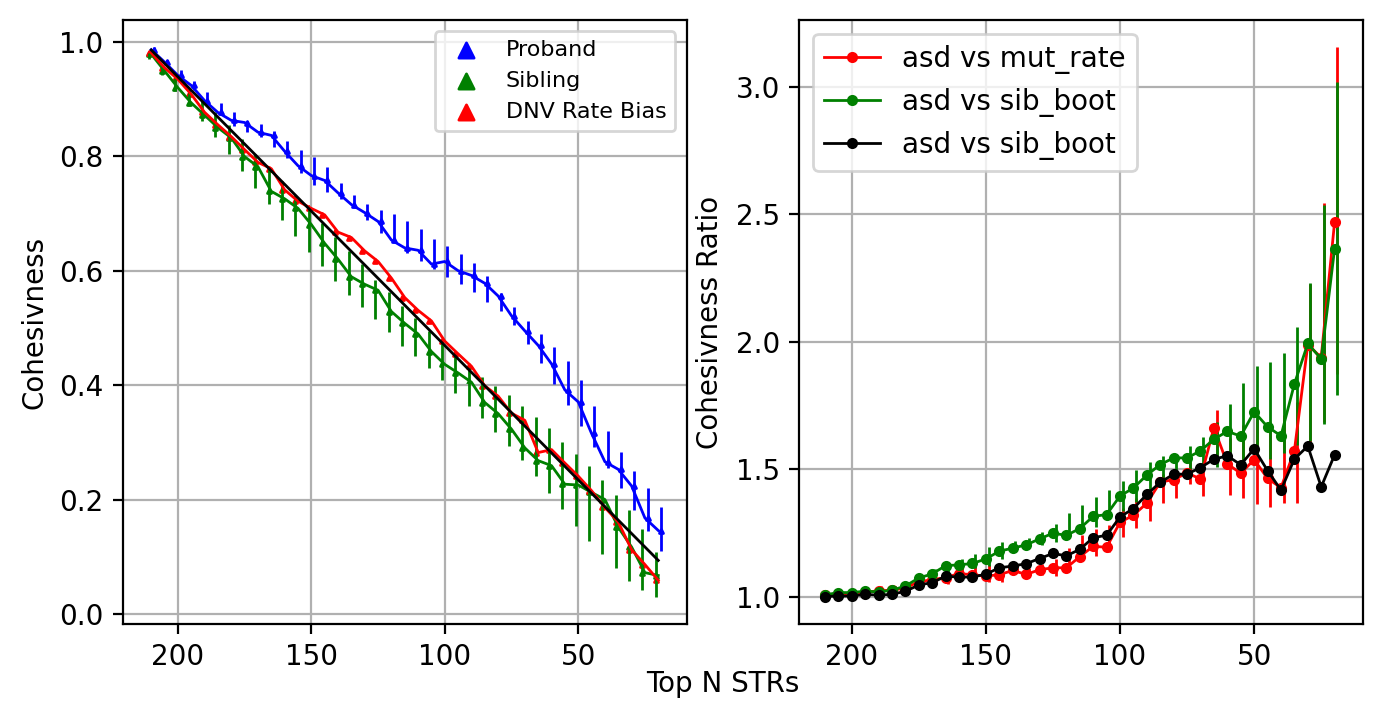

In [567]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(8,4), dpi=200)
for i, topN in enumerate(TopN_slice):
    values = ASD_Cohesivness_Boot[:, i]
    asd_lower, asd_upper = CI(np.array(values), 0.95)
    ax.vlines(topN-1, asd_lower, asd_upper, color = "blue", lw=1)
    x1 = ax.scatter(topN-1, ASD_Cohesivness[i], marker="^", s=2, color="blue")
    values2 = Sib_Cohesivness_Boot[:, i]
    lower, upper = CI(np.array(values2), 0.95)
    ax.vlines(topN+1, lower, upper, color = "green", lw=1)
    x2 = ax.scatter(topN+1, Sib_Cohesivness[i], marker="^", s=2, color="green")
    x3 = ax.scatter(topN+1, BGMR_Cohesivness[i], marker="^", s=2, color="red")
    
    ax2.vlines(topN-1, asd_lower/BGMR_Cohesivness[i], asd_upper/BGMR_Cohesivness[i], color = "red", lw=1)
    ax2.vlines(topN-1, asd_lower/np.mean(Sib_Cohesivness_Boot[:,i]), 
                       asd_upper/np.mean(Sib_Cohesivness_Boot[:,i]), color = "green", lw=1)
#ax.plot(TopN_slice, Sib_Cohesivness, color="green")
#ax.plot(TopN_slice, np.mean(Sib_Cohesivness_Boot, axis=0), color="green")
ax.plot(TopN_slice, ASD_Cohesivness, color="blue", lw=1)
ax.plot(TopN_slice, Sib_Cohesivness, color="green", lw=1)
ax.plot(TopN_slice, BGMR_Cohesivness, color="red", lw=1)
ax.plot(TopN_slice, np.array(TopN_slice)/213, color="black", lw=1)

ax2.plot(TopN_slice, np.array(ASD_Cohesivness)/np.array(BGMR_Cohesivness), 
        marker=".", lw=1, label="asd vs mut_rate", color='red')
ax2.plot(TopN_slice, np.array(ASD_Cohesivness)/np.mean(Sib_Cohesivness_Boot, axis=0), 
        marker=".", lw=1, label="asd vs sib_boot", color='green')
ax2.plot(TopN_slice, np.array(ASD_Cohesivness)/(np.array(TopN_slice)/213), 
        marker=".", lw=1, label="asd vs sib_boot", color='black')

lgnd = ax.legend([x1, x2, x3], ["Proband", "Sibling", "DNV Rate Bias"], prop={'size': 8})
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]

ax2.legend(loc="upper left")
ax.invert_xaxis()
ax2.invert_xaxis()
ax.grid(True)
ax2.grid(True)

ax.set_ylabel("Cohesivness")
ax2.set_ylabel("Cohesivness Ratio")
fig.text(0.5, 0.04, 'Top N STRs', ha='center')
plt.savefig("figs/Boot_TopN_Cohesivness.pdf")

### 3. Circuit Search

In [568]:
# Load Connectome and Weights
adj_mat = pd.read_csv(ConnFil, index_col=0)
g = LoadConnectome2(adj_mat) # Load Connectiome
EdgeWeightsDict = EdgeDict(g, keyon="label")
str2reg = STR2Region()

adj_mat_Hippomask = pd.read_csv("../dat/allen-mouse-conn/adj_mat.hippo_mask.csv", index_col=0)
g_hippomask = LoadConnectome2(adj_mat_Hippomask)

InfoDict = pk.load(open("dat/EdgeDict_selfInfo.pk", 'rb'))
PlainDict = pk.load(open("dat/EdgeDict_Uniform.pk", 'rb'))

In [569]:
# Get Random STR profile
"""
All_STRs = ASD_Bias_avgz.index.values
RandomExp = []
for i in range(10, 213, 1):
    tmp = []
    for j in range(100):
        STRSet = np.random.choice(All_STRs, i, replace=False)
        score, _ = ScoreSTRSet(g, STRSet, PlainDict)
        tmp.append(score)
    RandomExp.append(np.mean(tmp))
plt.plot(range(10, 213, 1), RandomExp)
plt.plot(range(10, 213, 1), [x/213 for x in range(10, 213, 1)])
"""

'\nAll_STRs = ASD_Bias_avgz.index.values\nRandomExp = []\nfor i in range(10, 213, 1):\n    tmp = []\n    for j in range(100):\n        STRSet = np.random.choice(All_STRs, i, replace=False)\n        score, _ = ScoreSTRSet(g, STRSet, PlainDict)\n        tmp.append(score)\n    RandomExp.append(np.mean(tmp))\nplt.plot(range(10, 213, 1), RandomExp)\nplt.plot(range(10, 213, 1), [x/213 for x in range(10, 213, 1)])\n'

In [592]:
ASD_Bias_avgz = pd.read_csv("dat/Jon_data/exp_bias-match-specific.csv")
ASD_Bias_avgz.columns = ["STR", "EFFECT", "Rank", "NGene"]
ASD_Bias_avgz = ASD_Bias_avgz.set_index("STR")

In [593]:
TopN_slice2 = np.arange(20, 100, 5)

ASD_Cohesivness_after_search = []
ASD_N_left = []
BGMR_Cohesivness_after_search = []
BGMR_N_left = []
Sib_Cohesivness_after_search = []
Sib_N_left = []
for topN in TopN_slice2:
    CirSTRs, cohe, conn = GreedyTrim(ASD_Bias_avgz, g, topN, InfoDict)
    ASD_N_left.append(len(CirSTRs))
    ASD_Cohesivness_after_search.append(cohe)
    
    CirSTRs, cohe, conn = GreedyTrim(BGMR_Meta_Spec, g, topN, InfoDict)
    BGMR_N_left.append(len(CirSTRs))
    BGMR_Cohesivness_after_search.append(cohe)
    
    CirSTRs, cohe, conn = GreedyTrim(Sib_Bias_spec, g, topN, InfoDict)
    Sib_N_left.append(len(CirSTRs))
    Sib_Cohesivness_after_search.append(cohe)

In [594]:
for x,y in zip(TopN_slice2, ASD_N_left):
    print(x,y)

20 10
25 18
30 21
35 22
40 25
45 30
50 27
55 47
60 49
65 55
70 56
75 57
80 62
85 73
90 70
95 90


In [617]:
CirSTRs, cohe, conn = GreedyTrim(ASD_Bias_avgz, g, 50, PlainDict)
print(cohe)
RegionDistributionsList(CirSTRs)

0.3796878015876759
Olfactory_areas 	 4 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Dorsal_peduncular_area; Taenia_tecta
Striatum 	 2 	 Nucleus_accumbens; Lateral_septal_nucleus_caudal_caudodorsal_part
Hippocampal_formation 	 4 	 Parasubiculum; Presubiculum; Subiculum_dorsal_part; Subiculum_ventral_part
Thalamus 	 4 	 Lateral_posterior_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus; Nucleus_of_reuniens; Submedial_nucleus_of_the_thalamus
Isocortex 	 14 	 Anterior_cingulate_area_dorsal_part; Anterior_cingulate_area_ventral_part; Agranular_insular_area_ventral_part; Infralimbic_area; Secondary_motor_area; Orbital_area_lateral_part; Orbital_area_medial_part; Orbital_area_ventrolateral_part; Prelimbic_area; Posterior_parietal_association_areas; Retrosplenial_area_lateral_agranular_part; Anteromedial_visual_area; Lateral_visual_area; Primary_visual_area
Hippocampal_region 	 4 	 Field_CA1; Field_CA2; Field_CA3; Dentate_gyrus
Cortical_subplate 	 3 	 Basolateral_amygdalar_n

In [619]:
Score, x = ScoreSTRSet(g, ASD_Bias_avgz.head(38).index.values, PlainDict)

In [620]:
0.3796878015876759 / Score

1.4704182913235653

In [596]:
CirSTRs, cohe, conn = GreedyTrim(BGMR_Meta_Spec, g, 40, InfoDict)
RegionDistributionsList(CirSTRs)

Olfactory_areas 	 1 	 Dorsal_peduncular_area
Pallidum 	 2 	 Medial_septal_nucleus; Triangular_nucleus_of_septum
Pons 	 2 	 Superior_central_nucleus_raphe; Nucleus_incertus
Striatum 	 1 	 Lateral_septal_nucleus_rostral_rostroventral_part
Midbrain 	 2 	 Interpeduncular_nucleus; Medial_pretectal_area
Thalamus 	 5 	 Anteromedial_nucleus_dorsal_part; Anteromedial_nucleus_ventral_part; Parataenial_nucleus; Nucleus_of_reuniens; Submedial_nucleus_of_the_thalamus
Isocortex 	 3 	 Infralimbic_area; Orbital_area_medial_part; Orbital_area_ventrolateral_part
Hypothalamus 	 4 	 Posterior_hypothalamic_nucleus; Dorsal_premammillary_nucleus; Paraventricular_hypothalamic_nucleus; Subparaventricular_zone


In [597]:
len(Sib_Cohesivness)

39

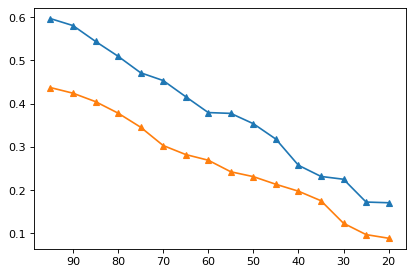

In [598]:
fig, ax = plt.subplots()
ax.plot(TopN_slice2, np.array(ASD_Cohesivness_after_search), marker="^")
ax.plot(TopN_slice2, Sib_Cohesivness_after_search, marker="^")
ax.invert_xaxis()

In [612]:
(0.38/38) / (0.36/50)

1.388888888888889

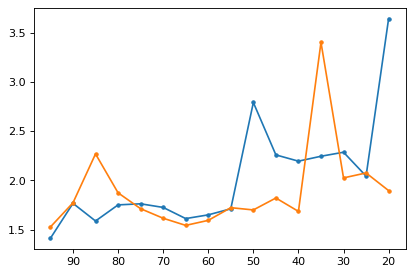

In [602]:
fig, ax = plt.subplots()
ax.plot(TopN_slice2, np.array(ASD_Cohesivness_after_search)/np.array([x/213 for x in ASD_N_left]), marker=".")
ax.plot(TopN_slice2, np.array(Sib_Cohesivness_after_search)/np.array([x/213 for x in Sib_N_left]), marker=".")
ax.invert_xaxis()
#ax.set_ylim((0,5))

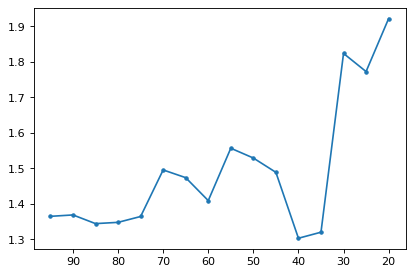

In [600]:
fig, ax = plt.subplots()
ax.plot(TopN_slice2, np.array(ASD_Cohesivness_after_search)/np.array(Sib_Cohesivness_after_search), marker=".")
#ax.plot(TopN_slice2, BGMR_Cohesivness)
ax.invert_xaxis()

In [604]:
TopN_slice2 = np.arange(20, 100, 5)
ASD_N_left_after_search_hippomask = []
ASD_Cohesivness_after_search_hippomask = []
BGMR_Cohesivness_after_search_hippomask = []
BGMR_N_left_after_search_hippomask = []
Sib_Cohesivness_after_search_hippomask = []
Sib_N_left_after_search_hippomask = []
for topN in TopN_slice2:
    CirSTRs, cohe, conn = GreedyTrim(ASD_Bias_avgz, g_hippomask, topN, InfoDict)
    ASD_N_left_after_search_hippomask.append(len(CirSTRs))
    ASD_Cohesivness_after_search_hippomask.append(cohe)
    
    CirSTRs, cohe, conn = GreedyTrim(BGMR_Meta_Spec, g_hippomask, topN, InfoDict)
    BGMR_N_left_after_search_hippomask.append(len(CirSTRs))
    BGMR_Cohesivness_after_search_hippomask.append(cohe)
    
    CirSTRs, cohe, conn = GreedyTrim(Sib_Bias_spec, g_hippomask, topN, InfoDict)
    Sib_N_left_after_search_hippomask.append(len(CirSTRs))
    Sib_Cohesivness_after_search_hippomask.append(cohe)

In [605]:
CirSTRs, cohe, conn = GreedyTrim(ASD_Bias_avgz, g_hippomask, 30, InfoDict)
RegionDistributionsList(CirSTRs)

Olfactory_areas 	 2 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area
Striatum 	 1 	 Nucleus_accumbens
Hippocampal_formation 	 2 	 Subiculum_dorsal_part; Subiculum_ventral_part
Thalamus 	 2 	 Lateral_posterior_nucleus_of_the_thalamus; Nucleus_of_reuniens
Isocortex 	 8 	 Anterior_cingulate_area_dorsal_part; Infralimbic_area; Orbital_area_medial_part; Orbital_area_ventrolateral_part; Prelimbic_area; Retrosplenial_area_lateral_agranular_part; Anteromedial_visual_area; Primary_visual_area
Cortical_subplate 	 2 	 Claustrum; Endopiriform_nucleus_dorsal_part


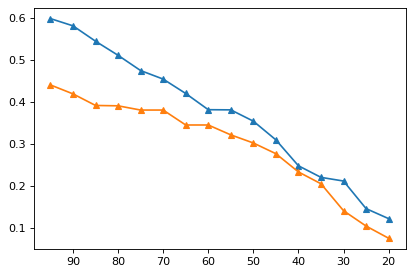

In [606]:
fig, ax = plt.subplots()
ax.plot(TopN_slice2, np.array(ASD_Cohesivness_after_search_hippomask), marker="^")
ax.plot(TopN_slice2, BGMR_Cohesivness_after_search_hippomask, marker="^")
ax.invert_xaxis()

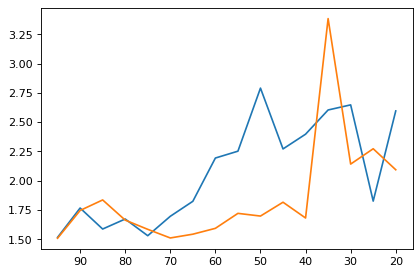

In [609]:
fig, ax = plt.subplots()
ax.plot(TopN_slice2, np.array(ASD_Cohesivness_after_search_hippomask)/np.array([x/213 for x in ASD_N_left_after_search_hippomask]))
ax.plot(TopN_slice2, np.array(Sib_Cohesivness_after_search_hippomask)/np.array([x/213 for x in Sib_N_left_after_search_hippomask]))
ax.invert_xaxis()
#ax.set_ylim((0,5))

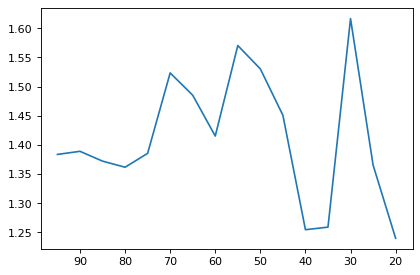

In [610]:
fig, ax = plt.subplots()
ax.plot(TopN_slice2, np.array(ASD_Cohesivness_after_search_hippomask)/np.array(Sib_Cohesivness_after_search_hippomask))
#ax.plot(TopN_slice2, BGMR_Cohesivness)
ax.invert_xaxis()

In [450]:
CirSTRs, cohe, conn = GreedyTrim(ASD_Bias_avgz, g_hippomask, 45, InfoDict)
RegionDistributionsList(CirSTRs)
cohe/(len(CirSTRs)/213)

Striatum 	 1 	 Caudoputamen
Thalamus 	 3 	 Lateral_posterior_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus; Parafascicular_nucleus
Isocortex 	 20 	 Anterior_cingulate_area_dorsal_part; Agranular_insular_area_posterior_part; Agranular_insular_area_ventral_part; Frontal_pole_cerebral_cortex; Gustatory_areas; Infralimbic_area; Primary_motor_area; Secondary_motor_area; Orbital_area_lateral_part; Orbital_area_medial_part; Orbital_area_ventrolateral_part; Prelimbic_area; Posterior_parietal_association_areas; Retrosplenial_area_lateral_agranular_part; Visceral_area; Anteromedial_visual_area; Lateral_visual_area; Primary_visual_area; Posterolateral_visual_area; posteromedial_visual_area
Cortical_subplate 	 2 	 Claustrum; Endopiriform_nucleus_dorsal_part


2.4677745797084385

In [457]:
CirSTRs, cohe, conn = GreedyTrim(ASD_Bias_avgz, g_hippomask, 59, InfoDict)
RegionDistributionsList(CirSTRs)
cohe/(len(CirSTRs)/213)

Olfactory_areas 	 4 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Dorsal_peduncular_area; Piriform_area
Striatum 	 2 	 Nucleus_accumbens; Caudoputamen
Hippocampal_formation 	 2 	 Entorhinal_area_lateral_part; Subiculum_dorsal_part
Thalamus 	 6 	 Central_lateral_nucleus_of_the_thalamus; Lateral_posterior_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus; Parafascicular_nucleus; Nucleus_of_reuniens; Submedial_nucleus_of_the_thalamus
Isocortex 	 23 	 Anterior_cingulate_area_dorsal_part; Anterior_cingulate_area_ventral_part; Agranular_insular_area_dorsal_part; Agranular_insular_area_posterior_part; Agranular_insular_area_ventral_part; Frontal_pole_cerebral_cortex; Gustatory_areas; Infralimbic_area; Primary_motor_area; Secondary_motor_area; Orbital_area_lateral_part; Orbital_area_medial_part; Orbital_area_ventrolateral_part; Prelimbic_area; Posterior_parietal_association_areas; Retrosplenial_area_lateral_agranular_part; Primary_somatosensory_area_trunk; Visceral_area; Anter

2.283937281932613